In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import string
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
stopWords.add("im")

In [3]:
train = pd.read_csv("../data/train.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### some simple word processing functions

In [6]:
punct = set(string.punctuation)
print(string.punctuation)

def loudness(line):
    '''
    unstripped line
    '''
    uppers = set(string.ascii_uppercase)
    all_chars = set(string.ascii_letters)
    
    upper_count = 0
    all_count = 0
    for ch in line:
        if ch in all_chars:
            all_count += 1
            
            if ch in uppers:
                upper_count += 1
    
#     print("loudness: {:0.4f}".format(upper_count / (all_count * 1.0)))
    return upper_count / (all_count * 1.0)  # make compatible with python 2.7 if others use

def repeating(line):
    '''
    stripped line prob works best
    '''
    
    temp = line.split()
    
    return 1.0 - (len(set(temp)) / (len(temp) * 1.0 ))

def build_vocab(line, v_dict, swords):
    '''
    parse the current line and add to v_dict counts
    '''
    
    word_list = line.split()
    
    # figure out how repetitious a line is so if it repeats a lot only add the first 10 words
    # so that one comment with something repeated 500 times doesn't blow out the vocab count
    if repeating(line) > 0.95:
        word_list = word_list[:10]
    
    # for each word in the line
    for word in word_list:
        
        # skip stop words for frequency count type stuff
        if word not in swords and len(word) > 1:

            # see if the word is in the vocab, if so increment
            if word in v_dict:
                v_dict[word] += 1

            # otherwise add word to dict with count of 1
            else:
                v_dict[word] = 1
        

def strip_line(line):
    line = line.replace(",", " ").replace("\n", " ")
    line = line.replace("..", " ").replace("??", " ").replace("!!", " ")
    line = line.replace(". ", " EOS ").replace("? ", " EOS ").replace("! ", " EOS ")
    line = "".join([_c if _c not in punct else " " for _c in line])
    
    word_list = line.lower().split()
    
    # if a sentence doesn't have eos add it?
    # might want to remove this when evaluating, not having terminating punctuation
    # is probably signal
    if word_list[-1] != "eos":
        word_list.append("eos")
        
    line = " ".join(word_list)
#     print(line)
    
#     if "yourselfgo" in line:
#         print("#########", line)
    
    return line

def punctuation_ratio(line):
    punct = set(string.punctuation)
    
    _c = 0
    
    for ch in line:
        if ch in punct:
            _c += 1
            
    return _c / len(line.split())

def urgency_ratio(line):
    _c = line.count("!")
    return _c / len(line.split())

def question_ratio(line):
    _c = line.count("!")
    return _c / len(line.split())
    
def period_ratio(line):
    _c = line.count(".")
    return _c / len(line.split())

# might be some pattern in length of messages?
def count_words(line):
    return len(line.split())



!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [17]:
good_stuff = train[np.sum(train.loc[:, ["toxic", "severe_toxic", "obscene", "insult", "threat", "identity_hate" ]], axis=1) == 0]

good_stuff.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0


In [18]:
bad_stuff = train[np.sum(train.loc[:, ["toxic", "severe_toxic", "obscene", "insult", "threat", "identity_hate" ]], axis=1) > 0]

bad_stuff.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
44,001956c382006abd,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0
51,001dc38a83d420cf,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
58,0021fe88bc4da3e6,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0


In [112]:
vocab_count_df = pd.DataFrame(list(vocab_count.items()), columns=["word", "count"])

vocab_count_df = vocab_count_df.sort_values("count", ascending=False)

vocab_count_df = vocab_count_df[vocab_count_df.loc[:, "word"] != "eos"]
# vocab_count_df.drop([0], inplace=True)
vocab_count_df.head(25)

,word,count
17,fuck,1119
22,fucking,627
23,bitch,466
7,shit,333
12,go,293
218,ass,267
190,suck,255
487,wikipedia,249
164,get,201
11,asshole,195


In [49]:
repeater.head()

6      0.000000
55     0.050000
181    0.000000
442    0.090909
579    0.000000
Name: comment_text, dtype: float64

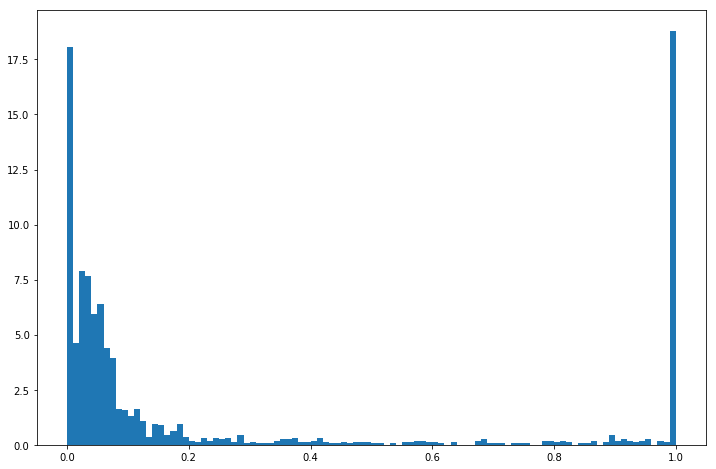

In [57]:
fig, ax = plt.subplots(figsize=(12, 8))

_ = ax.hist(loudness, bins=100, normed=True)